<a href="https://colab.research.google.com/github/Justholli/labs/blob/main/lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.utils import save_image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

import os
import math
from PIL import Image
from IPython.display import display
import glob
from glob import glob
from pathlib import Path

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
!unzip -oq '/content/gdrive/MyDrive/Mag22/123.zip' -d '/content/sample_data/celeb_faces'

Зададим трансформер

In [6]:
transform_obj = transforms.Compose ([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor()
])

In [36]:
dataroot = Path('/content/sample_data/celeb_faces')
dataset = datasets.ImageFolder(root=dataroot, transform=transform_obj)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

# 1

Модель с 4 сверточными слоями и 2 линейными в энкодере. latent_size во всех 6 экспериментах будет 100

In [8]:
class VAE(nn.Module):
    def __init__(self, latent_size=100):
        super(VAE, self).__init__()

        self.latent_size = latent_size

        self.l1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.l2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.l3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.l4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)

        self.l41 = nn.Linear(256*4*4, self.latent_size)
        self.l42 = nn.Linear(256*4*4, self.latent_size)

        self.f = nn.Linear(self.latent_size, 256*4*4)

        self.l5 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.l6 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.l7 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.l8 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1)

    def encoder(self, x_in):
        h = F.relu(self.l1(x_in))
        h = F.relu(self.l2(h))
        h = F.relu(self.l3(h))
        h = F.relu(self.l4(h))

        h = h.view(h.size(0), -1)

        return self.l41(h), self.l42(h)

    def decoder(self, z):
        z = self.f(z)
        z = z.view(-1, 256, 4, 4)

        z = F.relu(self.l5(z))
        z = F.relu(self.l6(z))
        z = F.relu(self.l7(z))
        z = torch.sigmoid(self.l8(z))

        return z

    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return torch.add(eps.mul(std), mu)

    def forward(self, x_in):
        mu, log_var = self.encoder(x_in)
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

In [9]:
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return (BCE + KLD)

In [10]:
def train(vae,dataAll,epoch):
    optimizer = optim.Adam(vae.parameters(), lr=0.0005)
    vae.train()

    train_loss = 0
    for idx, (data, _) in enumerate(dataAll):
      data = data.to(device)
      optimizer.zero_grad()

      r_batch, mu, log_var = vae(data)

      loss = loss_function(r_batch, data, mu, log_var)

      loss.backward()
      train_loss += loss.item()
      optimizer.step()
    print('\nEpoch: {} Train mean loss: {:.8f}'.format(epoch, train_loss / len(dataloader.dataset)))
    print("-------------------------------------------------")
    return train_loss

In [10]:
latent_dims = 100
vae1 = VAE(latent_dims).to(device)
n_epoches = 10
loss_hist1 = []
for epoch in tqdm.tqdm(range(n_epoches)):
    loss_epoch = train(vae1, dataloader, epoch)
    loss_hist1.append(loss_epoch)

 10%|█         | 1/10 [01:19<11:54, 79.37s/it]


Epoch: 0 Train mean loss: 6594.16603500
-------------------------------------------------


 20%|██        | 2/10 [02:32<10:06, 75.86s/it]


Epoch: 1 Train mean loss: 6379.56112203
-------------------------------------------------


 30%|███       | 3/10 [03:47<08:47, 75.37s/it]


Epoch: 2 Train mean loss: 6347.39294766
-------------------------------------------------


 40%|████      | 4/10 [05:00<07:25, 74.21s/it]


Epoch: 3 Train mean loss: 6332.94041094
-------------------------------------------------


 50%|█████     | 5/10 [06:13<06:09, 73.93s/it]


Epoch: 4 Train mean loss: 6324.10001609
-------------------------------------------------


 60%|██████    | 6/10 [07:26<04:54, 73.51s/it]


Epoch: 5 Train mean loss: 6316.99638438
-------------------------------------------------


 70%|███████   | 7/10 [08:40<03:41, 73.75s/it]


Epoch: 6 Train mean loss: 6312.06754609
-------------------------------------------------


 80%|████████  | 8/10 [09:53<02:27, 73.52s/it]


Epoch: 7 Train mean loss: 6307.98217891
-------------------------------------------------


 90%|█████████ | 9/10 [11:07<01:13, 73.59s/it]


Epoch: 8 Train mean loss: 6303.98985484
-------------------------------------------------


100%|██████████| 10/10 [12:19<00:00, 73.98s/it]


Epoch: 9 Train mean loss: 6301.29362500
-------------------------------------------------


In [23]:
vae1.to(device)

VAE(
  (l1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l41): Linear(in_features=4096, out_features=100, bias=True)
  (l42): Linear(in_features=4096, out_features=100, bias=True)
  (f): Linear(in_features=100, out_features=4096, bias=True)
  (l5): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l7): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l8): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

Сохраним веса в отдельный файл. Самый лучший результат по лоссу распечатаем

In [24]:
weights1 = vae1.state_dict()

In [25]:
file_path = '/content/gdrive/MyDrive/weights1.txt'

with open(file_path, 'w') as f:
    for key, value in weights1.items():
        f.write(f'{key}: {value}\n')

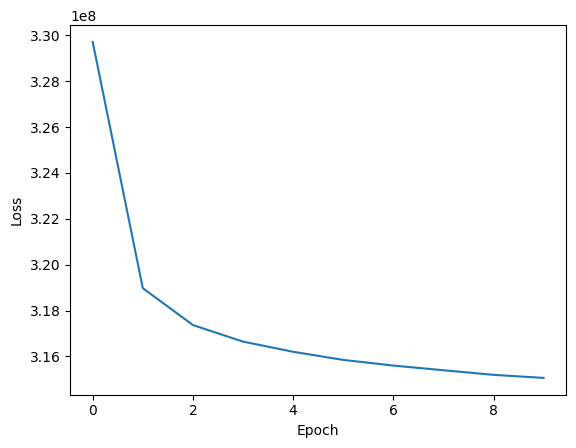

In [26]:
plt.plot(loss_hist1)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [30]:
def generateImg(vae,latentN,counter):
  z = (torch.rand(latentN)*2).to(device)
  sample = vae.decoder(z).to(device)
  save_image(sample.view(3, 64, 64), '/content/gdrive/MyDrive/' + 'sample_' + counter + '.jpg')

In [37]:
generateImg(vae1,100,"1_1")
generateImg(vae1,100,"1_2")

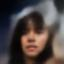

In [38]:
img_1_1 = Image.open('/content/gdrive/MyDrive/sample_1_1.jpg')
img_1_1

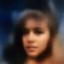

In [39]:
img_1_2 = Image.open('/content/gdrive/MyDrive/sample_1_2.jpg')
img_1_2

Видно что лосс уменьшается равномерно, без скачков, к концу обучения. Картинки тоже можно увидеть выше.

# 2

Постараемся уменьшить лосс. Добавим два новых полносвязных слоя и заменил функцию активации relu на elu. Это должно повлиять

In [11]:
class VAE(nn.Module):
    def __init__(self, latent_size=100):
        super(VAE, self).__init__()

        self.latent_size = latent_size

        self.l1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.l2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.l3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.l4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)

        self.fc1 = nn.Linear(256*4*4, 512)
        self.fc2 = nn.Linear(512, 256)

        self.l41 = nn.Linear(256, self.latent_size)
        self.l42 = nn.Linear(256, self.latent_size)

        self.f = nn.Linear(self.latent_size, 256*4*4)

        self.l5 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.l6 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.l7 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.l8 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1)

    def encoder(self, x_in):
        h = F.elu(self.l1(x_in))
        h = F.elu(self.l2(h))
        h = F.elu(self.l3(h))
        h = F.elu(self.l4(h))

        h = h.view(h.size(0), -1)

        h = F.relu(self.fc1(h))
        h = F.relu(self.fc2(h))

        return self.l41(h), self.l42(h)

    def decoder(self, z):
        z = self.f(z)
        z = z.view(-1, 256, 4, 4)

        z = F.elu(self.l5(z))
        z = F.elu(self.l6(z))
        z = F.elu(self.l7(z))
        z = torch.sigmoid(self.l8(z))

        return z

    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return torch.add(eps.mul(std), mu)

    def forward(self, x_in):
        mu, log_var = self.encoder(x_in)
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

In [41]:
latent_dims = 100
vae2 = VAE(latent_dims).to(device)
n_epoches = 10
loss_hist2 = []
for epoch in tqdm.tqdm(range(n_epoches)):
    loss_epoch = train(vae2, dataloader, epoch)
    loss_hist2.append(loss_epoch)

 10%|█         | 1/10 [01:17<11:33, 77.04s/it]


Epoch: 0 Train mean loss: 6641.97304578
-------------------------------------------------


 20%|██        | 2/10 [02:30<09:58, 74.77s/it]


Epoch: 1 Train mean loss: 6454.07985187
-------------------------------------------------


 30%|███       | 3/10 [03:45<08:45, 75.01s/it]


Epoch: 2 Train mean loss: 6413.30696969
-------------------------------------------------


 40%|████      | 4/10 [04:59<07:26, 74.42s/it]


Epoch: 3 Train mean loss: 6392.65467531
-------------------------------------------------


 50%|█████     | 5/10 [06:13<06:11, 74.30s/it]


Epoch: 4 Train mean loss: 6380.74196453
-------------------------------------------------


 60%|██████    | 6/10 [07:26<04:55, 73.87s/it]


Epoch: 5 Train mean loss: 6372.90337859
-------------------------------------------------


 70%|███████   | 7/10 [08:41<03:42, 74.28s/it]


Epoch: 6 Train mean loss: 6366.30725656
-------------------------------------------------


 80%|████████  | 8/10 [09:55<02:28, 74.13s/it]


Epoch: 7 Train mean loss: 6361.39201906
-------------------------------------------------


 90%|█████████ | 9/10 [11:08<01:13, 73.97s/it]


Epoch: 8 Train mean loss: 6357.83697359
-------------------------------------------------


100%|██████████| 10/10 [12:22<00:00, 74.28s/it]


Epoch: 9 Train mean loss: 6354.54891156
-------------------------------------------------


In [42]:
vae2.to(device)

VAE(
  (l1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (l41): Linear(in_features=256, out_features=100, bias=True)
  (l42): Linear(in_features=256, out_features=100, bias=True)
  (f): Linear(in_features=100, out_features=4096, bias=True)
  (l5): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l7): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l8): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [43]:
weights2 = vae2.state_dict()

In [52]:
file_path = '/content/gdrive/MyDrive/weights2.txt'

with open(file_path, 'w') as f:
    for key, value in weights2.items():
        f.write(f'{key}: {value}\n')

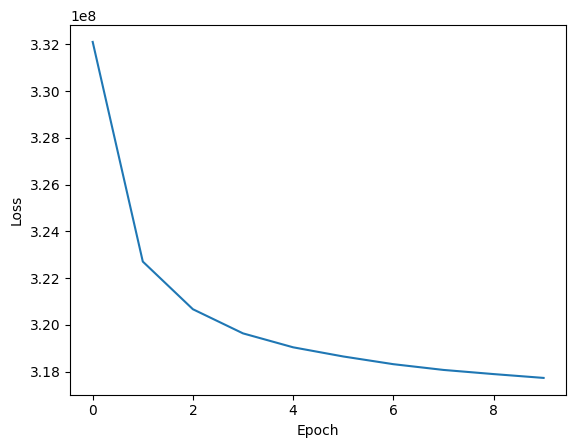

In [53]:
plt.plot(loss_hist2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Как видно по цифрам, лосс не уменьшился, а даже наоборот стал похудше. График примерно похож

In [54]:
generateImg(vae2,100,"2_1")
generateImg(vae2,100,"2_2")

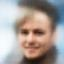

In [55]:
img_2_1 = Image.open('/content/gdrive/MyDrive/sample_2_1.jpg')
img_2_1

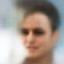

In [56]:
img_2_2 = Image.open('/content/gdrive/MyDrive/sample_2_2.jpg')
img_2_2

Кажется что картинки стали похуже

# 3

Добавим пакетную нормализацию для нормализования входных каждого слоя

In [57]:
class VAE(nn.Module):
    def __init__(self, latent_size=100):
        super(VAE, self).__init__()

        self.latent_size = latent_size

        self.l1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.l2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.l3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.l4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256*4*4, 512)
        self.fc2 = nn.Linear(512, 256)

        self.l41 = nn.Linear(256, self.latent_size)
        self.l42 = nn.Linear(256, self.latent_size)

        self.f = nn.Linear(self.latent_size, 256*4*4)

        self.l5 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.l6 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.bn6 = nn.BatchNorm2d(64)
        self.l7 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.bn7 = nn.BatchNorm2d(32)
        self.l8 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1)

    def encoder(self, x_in):
        h = F.elu(self.l1(x_in))
        h = F.elu(self.l2(h))
        h = F.elu(self.l3(h))
        h = F.elu(self.l4(h))

        h = h.view(h.size(0), -1)

        h = F.relu(self.fc1(h))
        h = F.relu(self.fc2(h))

        return self.l41(h), self.l42(h)

    def decoder(self, z):
        z = self.f(z)
        z = z.view(-1, 256, 4, 4)

        z = F.elu(self.l5(z))
        z = F.elu(self.l6(z))
        z = F.elu(self.l7(z))
        z = torch.sigmoid(self.l8(z))

        return z

    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return torch.add(eps.mul(std), mu)

    def forward(self, x_in):
        mu, log_var = self.encoder(x_in)
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

In [58]:
latent_dims = 100
vae3 = VAE(latent_dims).to(device)
n_epoches = 10
loss_hist3 = []
for epoch in tqdm.tqdm(range(n_epoches)):
    loss_epoch = train(vae3, dataloader, epoch)
    loss_hist3.append(loss_epoch)

 10%|█         | 1/10 [01:23<12:31, 83.48s/it]


Epoch: 0 Train mean loss: 6640.99492672
-------------------------------------------------


 20%|██        | 2/10 [02:38<10:29, 78.68s/it]


Epoch: 1 Train mean loss: 6449.53522953
-------------------------------------------------


 30%|███       | 3/10 [03:54<09:01, 77.33s/it]


Epoch: 2 Train mean loss: 6410.35887969
-------------------------------------------------


 40%|████      | 4/10 [05:09<07:37, 76.28s/it]


Epoch: 3 Train mean loss: 6392.34323172
-------------------------------------------------


 50%|█████     | 5/10 [06:23<06:17, 75.49s/it]


Epoch: 4 Train mean loss: 6380.79645969
-------------------------------------------------


 60%|██████    | 6/10 [07:38<05:02, 75.53s/it]


Epoch: 5 Train mean loss: 6372.77863656
-------------------------------------------------


 70%|███████   | 7/10 [08:53<03:45, 75.22s/it]


Epoch: 6 Train mean loss: 6367.00826094
-------------------------------------------------


 80%|████████  | 8/10 [10:07<02:29, 74.96s/it]


Epoch: 7 Train mean loss: 6362.27459125
-------------------------------------------------


 90%|█████████ | 9/10 [11:22<01:14, 74.91s/it]


Epoch: 8 Train mean loss: 6357.47348469
-------------------------------------------------


100%|██████████| 10/10 [12:37<00:00, 75.71s/it]


Epoch: 9 Train mean loss: 6353.09462375
-------------------------------------------------


In [59]:
vae3.to(device)

VAE(
  (l1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (l41): Linear(in_features=256, out_features=100, bias=True)
  (l42): Linear(in_features=256, out_features=100, bias=True)
  (f): Linear(in_features=100, out_features=4096, bias=True)
  (l5): ConvTranspose2d(256, 

In [60]:
weights3 = vae3.state_dict()

In [62]:
file_path = '/content/gdrive/MyDrive/weights3.txt'

with open(file_path, 'w') as f:
    for key, value in weights3.items():
        f.write(f'{key}: {value}\n')

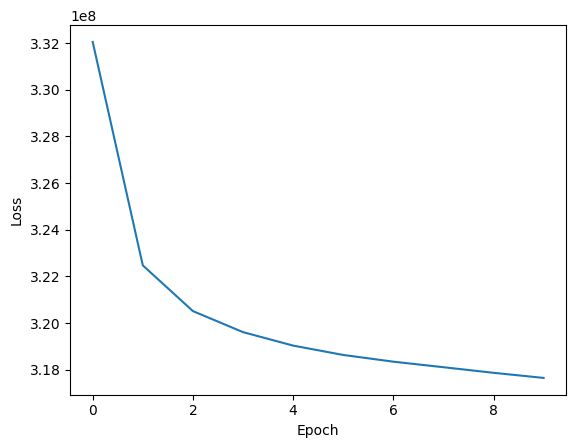

In [61]:
plt.plot(loss_hist3)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [63]:
generateImg(vae3,100,"3_1")
generateImg(vae3,100,"3_2")

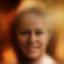

In [64]:
img_3_1 = Image.open('/content/gdrive/MyDrive/sample_3_1.jpg')
img_3_1

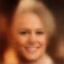

In [65]:
img_3_2 = Image.open('/content/gdrive/MyDrive/sample_3_2.jpg')
img_3_2

Тоже не повлияло на лосс

# 4

In [67]:
import tqdm
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import CyclicLR

# Модель VAE
class VAE(nn.Module):
    def __init__(self, latent_size=100):
        super(VAE, self).__init__()

        self.latent_size = latent_size

        # Encoder
        self.enc_conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(32)
        self.enc_conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(64)
        self.enc_conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.enc_bn3 = nn.BatchNorm2d(128)
        self.enc_conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.enc_bn4 = nn.BatchNorm2d(256)
        self.enc_conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1)
        self.enc_bn5 = nn.BatchNorm2d(512)

        self.fc_mu = nn.Linear(512*2*2, self.latent_size)
        self.fc_log_var = nn.Linear(512*2*2, self.latent_size)

        # Decoder
        self.fc = nn.Linear(self.latent_size, 512*2*2)

        self.dec_conv1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(256)
        self.dec_conv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(128)
        self.dec_conv3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.dec_bn3 = nn.BatchNorm2d(64)
        self.dec_conv4 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.dec_bn4 = nn.BatchNorm2d(32)
        self.dec_conv5 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1)

    def encoder(self, x_in):
        h = F.relu(self.enc_bn1(self.enc_conv1(x_in)))
        h = F.relu(self.enc_bn2(self.enc_conv2(h)))
        h = F.relu(self.enc_bn3(self.enc_conv3(h)))
        h = F.relu(self.enc_bn4(self.enc_conv4(h)))
        h = F.relu(self.enc_bn5(self.enc_conv5(h)))

        h = h.view(h.size(0), -1)  # Flatten the feature map
        return self.fc_mu(h), self.fc_log_var(h)

    def decoder(self, z):
        z = self.fc(z)
        z = z.view(-1, 512, 2, 2)

        z = F.relu(self.dec_bn1(self.dec_conv1(z)))
        z = F.relu(self.dec_bn2(self.dec_conv2(z)))
        z = F.relu(self.dec_bn3(self.dec_conv3(z)))
        z = F.relu(self.dec_bn4(self.dec_conv4(z)))
        z = self.dec_conv5(z)

        return z

    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x_in):
        mu, log_var = self.encoder(x_in)
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# Функция потерь
def loss_function(reconstructed, original, mu, log_var):
    BCE = F.binary_cross_entropy_with_logits(reconstructed, original, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

# Функция обучения
def train(model, dataloader, optimizer, scaler, device):
    model.train()
    train_loss = 0
    for data in dataloader:
        data = data[0].to(device)  # Перемещение данных на GPU
        optimizer.zero_grad()

        with autocast():
            reconstructed, mu, log_var = model(data)
            loss = loss_function(reconstructed, data, mu, log_var)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
    return train_loss / len(dataloader.dataset)

# Настройка устройства, модели и гиперпараметров
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dims = 100
vae4 = VAE(latent_dims).to(device)
optimizer = torch.optim.Adam(vae4.parameters(), lr=1e-3)
scaler = GradScaler()
n_epoches = 5
loss_hist4 = []

# Обучение модели
for epoch in tqdm.tqdm(range(n_epoches)):
    loss_epoch = train(vae4, dataloader, optimizer, scaler, device)
    loss_hist4.append(loss_epoch)

print("Training complete. Loss history:", loss_hist4)

100%|██████████| 5/5 [06:54<00:00, 82.94s/it]

Training complete. Loss history: [6682.74678546875, 6461.47600546875, 6417.4856509375, 6395.2260021875, 6381.7342928125]


In [69]:
vae4.to(device)

VAE(
  (enc_conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_mu): Linear(in_features=2048, out_features=100, bias=True)
  (fc_log_var): Linear(in_features=2048, out_features

In [70]:
weights4 = vae4.state_dict()

In [71]:
file_path = '/content/gdrive/MyDrive/weights4.txt'

with open(file_path, 'w') as f:
    for key, value in weights4.items():
        f.write(f'{key}: {value}\n')

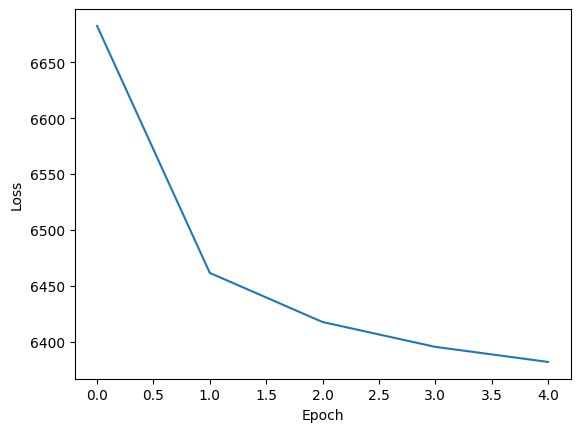

In [72]:
plt.plot(loss_hist4)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [73]:
generateImg(vae4,100,"4_1")
generateImg(vae4,100,"4_2")

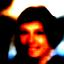

In [74]:
img_4_1 = Image.open('/content/gdrive/MyDrive/sample_4_1.jpg')
img_4_1

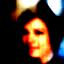

In [75]:
img_4_2 = Image.open('/content/gdrive/MyDrive/sample_4_2.jpg')
img_4_2

Вот что еще попробовал

Изменил архитектуру модели, добавив сверточные и транспонированные сверточные слои для работы с изображениями.<br>
Добавил слои батч-нормализации для стабилизации обучения и ускорения сходимости модели.<br>
Попробовал разные значения размера латентного пространства, чтобы изучить различные аспекты данных.<br>
Заменил функцию потерь на torch.nn.functional.binary_cross_entropy_with_logits для устойчивости обучения модели VAE.<br>
Применил автоматическое смешивание для ускорения обучения на GPU.<br>
Настроил гиперпараметры, такие как скорость обучения и параметры оптимизатора, для улучшения сходимости модели.<br>
Исправил ошибки и предупреждения, такие как вызов функции lr_scheduler.step() перед optimizer.step(), и обработал предупреждения о безопасности автоматического смешивания.<br>
Убедился, что декодер также состоит из сверточных слоев, чтобы правильно восстанавливать изображения из латентного представления.<br>

loss по итогу не уменьшается ниже 6300